Using device: cuda
Loaded 29 class names.
Model 'eva02_tiny_patch14_224.mim_in22k' loaded with best weights.

--- Analyzing: Tripathaka_11.jpg ---
True Class:      Tripathaka(1)
Predicted Class: Tripathaka(1) (Confidence: 0.9317)
Visualization saved to XAI_CAM_Tripathaka_11_jpg.png


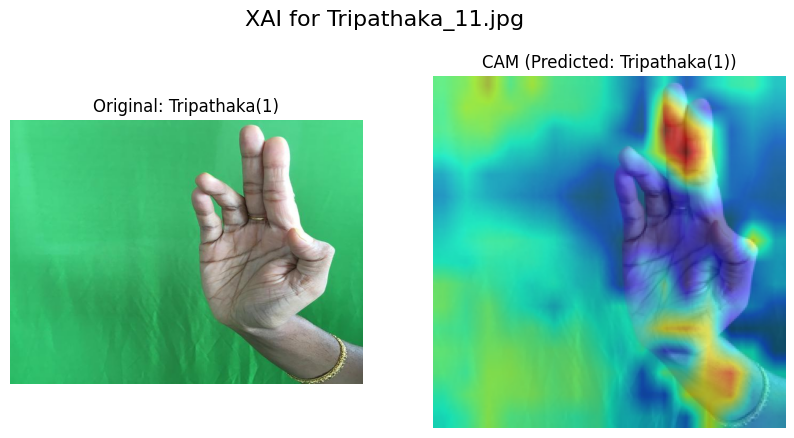


--- Analyzing: Ardhapathaka_11.jpg ---
True Class:      Ardhapathaka(1)
Predicted Class: Ardhapathaka(1) (Confidence: 0.8214)
Visualization saved to XAI_CAM_Ardhapathaka_11_jpg.png


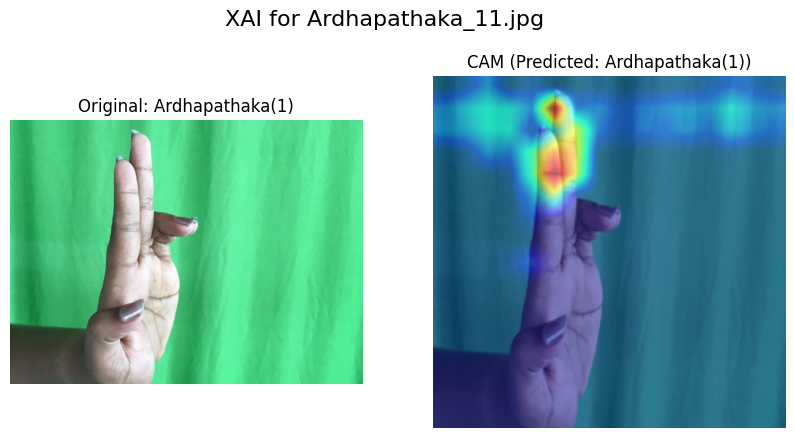


--- Analyzing: Pathaka_11.jpg ---
True Class:      Pathaka(1)
Predicted Class: Pathaka(1) (Confidence: 0.9198)
Visualization saved to XAI_CAM_Pathaka_11_jpg.png


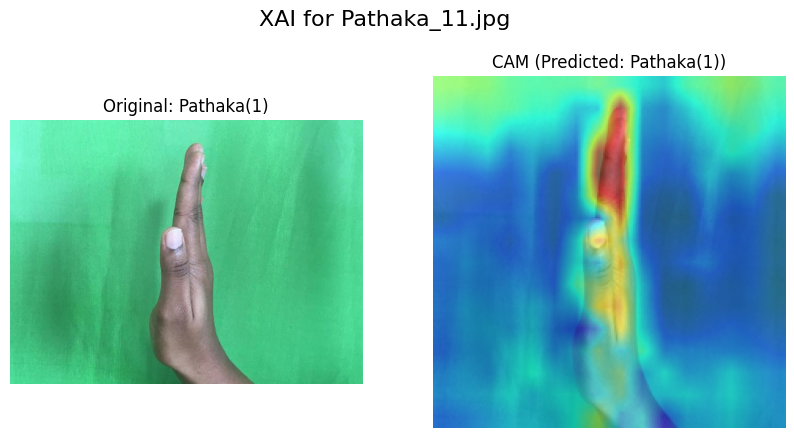


--- Analyzing: Aralam_4.jpg ---
True Class:      Aralam(1)
Predicted Class: Aralam(1) (Confidence: 0.9378)
Visualization saved to XAI_CAM_Aralam_4_jpg.png


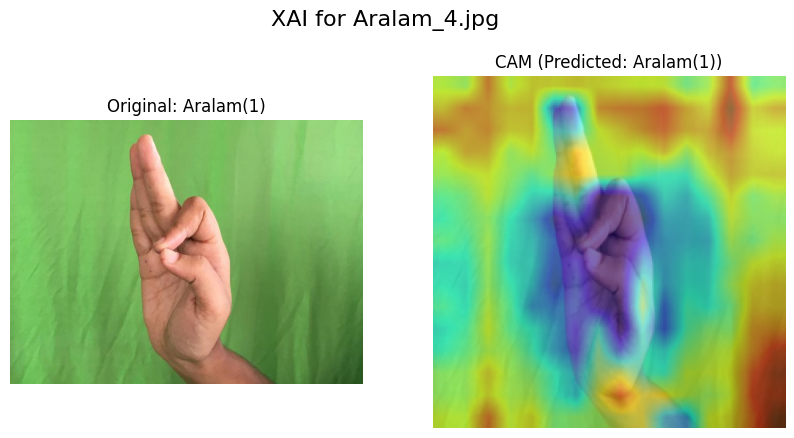


🎉 XAI visualizations complete!


In [7]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- CONFIGURATION (Use the same config as your training script) ---
config = {
    'data_path': r'dataset_split/',
    'model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'img_size': 224,
    'drop_rate': 0.4,
    'drop_path_rate': 0.2,
}

# --- HELPER FUNCTION FOR ViT (This is the key fix) ---
def reshape_transform(tensor, height=16, width=16):
    """
    Reshapes the output of a Vision Transformer block to a 2D feature map.
    """
    # The (H, W) for a 224x244 image with patch size 14 is 16x16
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# --- SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load class names from the dataset structure
val_test_transform = transforms.Compose([
    transforms.Resize((config['img_size'], config['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
full_dataset = ImageFolder(root=os.path.join(config['data_path'], 'train'))
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Loaded {num_classes} class names.")

# --- Load Model ---
model = timm.create_model(
    config['model_name'], pretrained=False, num_classes=num_classes,
    drop_rate=config['drop_rate'], drop_path_rate=config['drop_path_rate']
)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()
model.to(device)
print(f"Model '{config['model_name']}' loaded with best weights.")

# --- Select Target Layer for Grad-CAM ---
# For ViTs, model.blocks[-1].norm1 is a good layer to target.
target_layers = [model.blocks[-1].norm1]

# --- CUSTOMIZE: Choose Images for Visualization ---
# ❗️ IMPORTANT: Change these paths to images from your test set!
# Focus on the classes the model found confusing, like Tripathaka.
test_image_paths = [
    os.path.join(config['data_path'], 'test', 'Tripathaka(1)', 'Tripathaka_11.jpg'),
    os.path.join(config['data_path'], 'test', 'Ardhapathaka(1)', 'Ardhapathaka_11.jpg'),
    os.path.join(config['data_path'], 'test', 'Pathaka(1)', 'Pathaka_11.jpg'),
    os.path.join(config['data_path'], 'test', 'Aralam(1)', 'Aralam_4.jpg'), # A well-performing class
]

# --- Grad-CAM Visualization Loop ---
cam_algorithm = GradCAM

for img_path in test_image_paths:
    if not os.path.exists(img_path):
        print(f"WARNING: Image not found at {img_path}. Skipping.")
        continue

    original_image = Image.open(img_path).convert('RGB')
    input_tensor = val_test_transform(original_image).unsqueeze(0).to(device)
    true_class_name = os.path.basename(os.path.dirname(img_path))
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_prob, predicted_label_idx = torch.max(probabilities, 1)
    predicted_class_name = class_names[predicted_label_idx.item()]
    
    print(f"\n--- Analyzing: {os.path.basename(img_path)} ---")
    print(f"True Class:      {true_class_name}")
    print(f"Predicted Class: {predicted_class_name} (Confidence: {predicted_prob.item():.4f})")

    targets = [ClassifierOutputTarget(predicted_label_idx.item())]
    
    # Construct the CAM object with the reshape_transform
    with cam_algorithm(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

    # Resize the image to match the model's input size for visualization
    original_image_resized = original_image.resize((config['img_size'], config['img_size']))
    img_np = np.array(original_image_resized) / 255.0
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    # Display and save results
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image); axes[0].set_title(f"Original: {true_class_name}"); axes[0].axis('off')
    axes[1].imshow(cam_image); axes[1].set_title(f"CAM (Predicted: {predicted_class_name})"); axes[1].axis('off')
    plt.suptitle(f"XAI for {os.path.basename(img_path)}", fontsize=16)
    
    output_filename = f"XAI_CAM_{os.path.basename(img_path).replace('.', '_')}.png"
    plt.savefig(output_filename)
    print(f"Visualization saved to {output_filename}")
    plt.show()

print("\n🎉 XAI visualizations complete!")